In [1]:
# Import packages
import os
import datetime as dt
import numpy as np
import pandas as pd
import random

# Import libraries for technical indicators
import ta

# Libraries for data
import investpy
# import eikon as ek
# import quandl as q

# Setting for the plot
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop




In [2]:

# ==================================================================
# Import the data via investpy
# Set the date bounds
# dt.datetime(2019,1,1)
start = '10/12/2016'
# dt.datetime.now().strftime('%d/%m/%Y')
end = '05/09/2021'

# Assets
df = investpy.get_currency_cross_historical_data(currency_cross = 'USD/JPY', from_date = start, to_date = end)
# Add the non-trading days
# USDJPY = USDJPY.reindex(pd.date_range(start = start, end = end, freq = 'D'))
# fillna by linear interpolation
# USDJPY = USDJPY.interpolate(method='linear', axis=0)
# fillna in the column 'Currency' by 'JPY'
# USDJPY['Currency'] = USDJPY['Currency'].fillna('JPY')
# Confirm the results
# USDJPY.head()




In [3]:
# Define the Rogers & Satchell volatility
# Data should have ohlc values
def Rogers_Satchell_volatility(data, periods):
    ratio = np.log(data['High'] / data['Close']) * np.log(data['High'] / data['Open']) 
    + np.log(data['Low'] / data['Close']) * np.log(data['Low'] / data['Open'])
    return np.sqrt(ratio.rolling(periods).mean())

# =========================================================
# Find the return based on the close price
df['Return_' + 'Close'] = np.log(df['Close'] / df['Close'].shift(1))

# Set up the RSI indicator
RSI_para = 7
df['RSI_' + str(RSI_para)] = ta.momentum.RSIIndicator(df['Close'], window=RSI_para).rsi()

# Set up the Rogers & Satchell volatility
RS_volitality_para = 5
df['volitality_' + str(RS_volitality_para)] = Rogers_Satchell_volatility(df, periods = RS_volitality_para)

# Define the direction
df['direction'] = np.where(df['Return_' + 'Close'] > 0, 1, 0)


In [4]:
# Drop the currency column and drop Nan
df = df.drop(columns=['Currency']).dropna()
# df.head()

In [5]:
def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(seed = 100)

In [6]:
# Set up the model Best model (64, 64), (61,61), (52,52)
model = Sequential()
optimizer = Adam(learning_rate=0.0001)
model.add(Dense(64, activation = keras.layers.LeakyReLU(alpha = 0.01), 
                input_shape = (len(df.columns[:-1]),)))
model.add(Dense(64, activation = keras.layers.LeakyReLU(alpha = 0.01)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Copy data up to the cutoff date (as the training data)
cutoff = '31/12/2019'
training_data = df[df.index < cutoff].copy()

# Find the mean and standard deviation
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

# Copy data up to the cutoff date (as the testing data)
test_data = df[df.index >= cutoff].copy()
test_data_ = (test_data - mu) / std


In [7]:
# %%time
# Fit the training data and the buy-sell signals
# Shuffle is prohibited because we do not know the future prices when we really do the prediction
model.fit(training_data[list(training_data.columns)[:-1]], training_data['direction'],
          epochs=50, verbose=False, validation_split=0.2, 
          shuffle=False)

In [8]:
# Store the hsitory of the model fitting
res = pd.DataFrame(model.history.history)

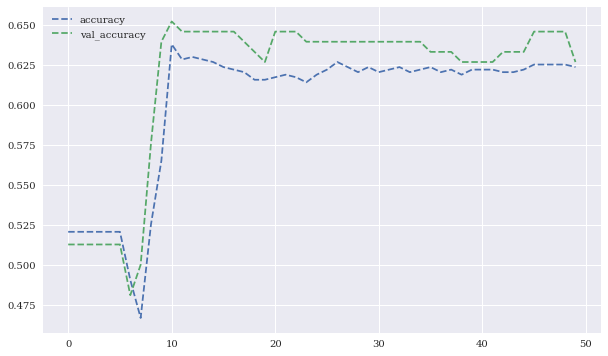

In [9]:
# Plot the accuracy and val_accuracy of the training data
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [10]:
cols = list(training_data.columns)[:-1]
# Evaluate the prediction of the training data
model.evaluate(training_data_[cols], training_data['direction'])

25/25 [==============================] - 0s 641us/step - loss: 0.6739 - accuracy: 0.6886


[0.6738782525062561, 0.6886075735092163]

In [11]:
# Predict the signals
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

In [12]:
# Transform the signals into 1 and -1
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [13]:
# Find the return with the predicted signals
training_data['strategy'] = (training_data['prediction'] *
                                      training_data['Return_' + 'Close'])

In [14]:
# Evaluate the return in the training data
training_data[['Return_' + 'Close', 'strategy']].sum().apply(np.exp)

Return_Close    0.929792
strategy        4.004065
dtype: float64

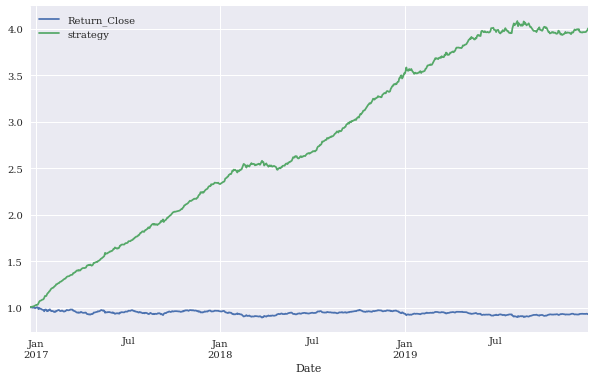

In [15]:
# Plot the return in the training data
training_data[['Return_'+'Close', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6));

In [16]:
# Evaluate the prediction of the test data
model.evaluate(test_data_[cols], test_data['direction'])

14/14 [==============================] - 0s 645us/step - loss: 0.8345 - accuracy: 0.5649


[0.834546685218811, 0.5649202466011047]

In [17]:
# Predict the signals
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

In [18]:
# Transform the signals into 1 and -1
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [19]:
# Find the return with the predicted signals
test_data['strategy'] = (test_data['prediction'] *
                                  test_data['Return_'+'Close'])


In [20]:
# Show the results
test_data[['Return_'+'Close', 'strategy']].sum().apply(np.exp)

Return_Close    1.007992
strategy        1.273143
dtype: float64

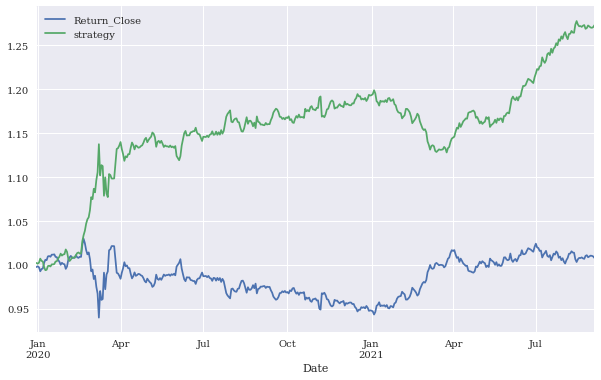

In [21]:
# Plot the results
test_data[['Return_'+'Close', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));
